# The Life Cycle Model: Theory vs Data

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/lifecyclemodeltheoryvsdata#launch)

National registry data on income and wealth from Scandinavian countries (esp. Norway) have recently become available (with a lot of security) to some (lucky!) researchers.   These data offer a uniquely powerful tool for testing (and improving) our models of consumption and saving behavior over the life cycle.

This notebook is an example of how to construct a life cycle model with the HARK toolkit that makes predictions that can be compared to the raw data statistics=.

For example, some papers have tabulated information about the **growth rate** of assets at different ages over the life cycle.

The default parameters of the HARK life cycle model have not been optmized to match features of the Norwegian data; a first step in a real "structural" estimation would be to use Norwegian calibrate the inputs to the model (like the profile of income, and the magnitude of income shocks, over the life cycle), and then to find the values of parameters like the time preference rate that allow the model to fit the data best.  (See [SolvingMicroDSOPs](https://www.econ2.jhu.edu/people/ccarroll/SolvingMicroDSOPs) for how this can be done, and search for the corresponding HARK content using [our documentation](https://hark.readthedocs.io)).

In [1]:
# Initial imports and notebook setup, click arrow to show

# The consumption-saving micro model
from matplotlib import pyplot as plt
import warnings
import HARK.ConsumptionSaving.ConsIndShockModel as cShksModl
from HARK.utilities import plot_funcs  # Some tools
import pandas as pd

import numpy as np

In [2]:
# ---------------------------------------------------------------------------------
# - Define all of the model parameters for SolvingMicroDSOPs and ConsumerExamples -
# ---------------------------------------------------------------------------------

exp_nest = 3  # Number of times to "exponentially nest" when constructing a_grid
aXtraMin = 0.001  # Minimum end-of-period "assets above minimum" value
aXtraMax = 20  # Maximum end-of-period "assets above minimum" value
aXtraHuge = None  # A very large value of assets to add to the grid, not used
aXtraExtra = None  # Some other value of assets to add to the grid, not used
aXtraCount = 8  # Number of points in the grid of "assets above minimum"

# Artificial borrowing constraint; imposed minimum level of end-of period assets
BoroCnstArt = 0.0
CubicBool = (
    True  # Use cubic spline interpolation when True, linear interpolation when False
)
vFuncBool = False  # Whether to calculate the value function during solution

Rfree = 1.03  # Interest factor on assets
PermShkCount = (
    7  # Number of points in discrete approximation to permanent income shocks
)
TranShkCount = (
    7  # Number of points in discrete approximation to transitory income shocks
)
UnempPrb = 0.005  # Probability of unemployment while working
UnempPrbRet = 0.000  # Probability of "unemployment" while retired
IncUnemp = 0.0  # Unemployment benefits replacement rate
IncUnempRet = 0.0  # "Unemployment" benefits when retired

final_age = 90  # Age at which the problem ends (die with certainty)
retirement_age = 65  # Age at which the consumer retires
initial_age = 25  # Age at which the consumer enters the model
TT = final_age - initial_age  # Total number of periods in the model
retirement_t = retirement_age - initial_age - 1

# Initial guess of the coefficient of relative risk aversion during estimation (rho)
CRRA_start = 4.0
# Initial guess of the adjustment to the discount factor during estimation (beth)
DiscFacAdj_start = 0.99
DiscFacAdj_bound = [
    0.0001,
    15.0,
]  # Bounds for beth; if violated, objective function returns "penalty value"
CRRA_bound = [
    0.0001,
    15.0,
]  # Bounds for rho; if violated, objective function returns "penalty value"

# Expected growth rates of permanent income over the lifecycle, starting from age 25
PermGroFac = [
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.025,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    1.01,
    0.7,  # <-- This represents retirement
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
]

# Age-varying discount factors over the lifecycle, lifted from Cagetti (2003)
DiscFac_timevary = [
    1.064914,
    1.057997,
    1.051422,
    1.045179,
    1.039259,
    1.033653,
    1.028352,
    1.023348,
    1.018632,
    1.014198,
    1.010037,
    1.006143,
    1.002509,
    0.9991282,
    0.9959943,
    0.9931012,
    0.9904431,
    0.9880143,
    0.9858095,
    0.9838233,
    0.9820506,
    0.9804866,
    0.9791264,
    0.9779656,
    0.9769995,
    0.9762239,
    0.9756346,
    0.9752274,
    0.9749984,
    0.9749437,
    0.9750595,
    0.9753422,
    0.9757881,
    0.9763936,
    0.9771553,
    0.9780698,
    0.9791338,
    0.9803439,
    0.981697,
    0.8287214,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
    0.9902111,
]

# Survival probabilities over the lifecycle, starting from age 25
LivPrb = [
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,  # <-- automatic survival to age 65
    0.98438596,
    0.98438596,
    0.98438596,
    0.98438596,
    0.98438596,
    0.97567062,
    0.97567062,
    0.97567062,
    0.97567062,
    0.97567062,
    0.96207901,
    0.96207901,
    0.96207901,
    0.96207901,
    0.96207901,
    0.93721595,
    0.93721595,
    0.93721595,
    0.93721595,
    0.93721595,
    0.63095734,
    0.63095734,
    0.63095734,
    0.63095734,
    0.63095734,
]


# Standard deviations of permanent income shocks by age, starting from age 25
PermShkStd = [
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.0,
    0.0,
    0.0,  # <-- no permanent income shocks after retirement
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]

# Standard deviations of transitory income shocks by age, starting from age 25
TranShkStd = [
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1,
    0.0,
    0.0,
    0.0,  # <-- no transitory income shocs after retirement
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]

# Age groups for the estimation: calculate average wealth-to-permanent income ratio
# for consumers within each of these age groups, compare actual to simulated data
empirical_cohort_age_groups = [
    [26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35],
    [36, 37, 38, 39, 40],
    [41, 42, 43, 44, 45],
    [46, 47, 48, 49, 50],
    [51, 52, 53, 54, 55],
    [56, 57, 58, 59, 60],
]

initial_wealth_income_ratio_vals = [
    0.17,
    0.5,
    0.83,
]  # Three point discrete distribution of initial w
initial_wealth_income_ratio_probs = [
    0.33333,
    0.33333,
    0.33334,
]  # Equiprobable discrete distribution of initial w
num_agents = 10000  # Number of agents to simulate
bootstrap_size = 50  # Number of re-estimations to do during bootstrap
seed = 31382  # Just an integer to seed the estimation


# Dictionary that can be passed to ConsumerType to instantiate
init_consumer_objects = {
    "CRRA": CRRA_start,
    "Rfree": Rfree,
    "PermGroFac": PermGroFac,
    "BoroCnstArt": BoroCnstArt,
    "PermShkStd": PermShkStd,
    "PermShkCount": PermShkCount,
    "TranShkStd": TranShkStd,
    "TranShkCount": TranShkCount,
    "T_cycle": TT,
    "UnempPrb": UnempPrb,
    "UnempPrbRet": UnempPrbRet,
    "T_retire": retirement_t,
    "T_age": TT + 1,
    "IncUnemp": IncUnemp,
    "IncUnempRet": IncUnempRet,
    "aXtraMin": aXtraMin,
    "aXtraMax": aXtraMax,
    "aXtraCount": aXtraCount,
    "aXtraExtra": [aXtraExtra, aXtraHuge],
    "aXtraNestFac": exp_nest,
    "LivPrb": LivPrb,
    "DiscFac": DiscFac_timevary,
    "AgentCount": num_agents,
    "seed": seed,
    "tax_rte": 0.0,
    "vFuncBool": vFuncBool,
    "CubicBool": CubicBool,
}

In [3]:
# Set up default values for CRRA, DiscFac, and simulation variables in the dictionary
init_consumer_objects[
    "CRRA"
] = 2.00  # Default coefficient of relative risk aversion (rho)
# Default intertemporal discount factor (beta)
init_consumer_objects["DiscFac"] = 0.97
# Aggregate permanent income growth factor
init_consumer_objects["PermGroFacAgg"] = 1.0
init_consumer_objects["aNrmInitMean"] = -10.0  # Mean of log initial assets
# Standard deviation of log initial assets
init_consumer_objects["aNrmInitStd"] = 1.0
# Mean of log initial permanent income
init_consumer_objects["pLvlInitMean"] = 0.0
init_consumer_objects[
    "pLvlInitStd"
] = 0.0  # Standard deviation of log initial permanent income

In [4]:
# Make an instance of a lifecycle consumer to be used for estimation
LifeCyclePop = cShksModl.IndShockConsumerType(**init_consumer_objects)

In [5]:
# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()  # Obtain consumption rules by age
LifeCyclePop.unpack("cFunc")  # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ["aNrm", "aLvl", "pLvl", "mNrm", "cNrm", "TranShk"]

LifeCyclePop.T_sim = 120  # Nobody lives to be older than 145 years (=25+120)
# Construct the age-25 distribution of income and assets
LifeCyclePop.initialize_sim()
LifeCyclePop.simulate()  # Simulate a population behaving according to this model

{'aNrm': array([[0.15124943, 0.15125731, 0.15126049, ..., 0.15125088, 0.15125539,
         0.151246  ],
        [0.22518609, 0.18215553, 0.35807711, ..., 0.27812983, 0.17667259,
         0.15458877],
        [0.32597743, 0.38337328, 0.37146627, ..., 0.41407619, 0.2350288 ,
         0.25442612],
        ...,
        [0.01608449, 0.35744504, 0.23336433, ..., 0.46517625, 0.49899843,
         0.52070675],
        [0.15126599, 0.40279067, 0.15865312, ..., 0.63411803, 0.59225189,
         0.50505825],
        [0.21086177, 0.43497386, 0.10261234, ..., 0.49429389, 0.5951336 ,
         0.48172896]]),
 'aLvl': array([[0.16005575, 0.14242219, 0.14242518, ..., 0.16005728, 0.16712597,
         0.13183977],
        [0.2633008 , 0.189512  , 0.31746737, ..., 0.32520573, 0.23338661,
         0.13744097],
        [0.42114459, 0.37555838, 0.31010102, ..., 0.42203979, 0.29234057,
         0.23937429],
        ...,
        [0.01270434, 0.43632293, 0.62845058, ..., 0.70423178, 0.57352318,
         0.6577561

Consumption as a function of market resources while working:


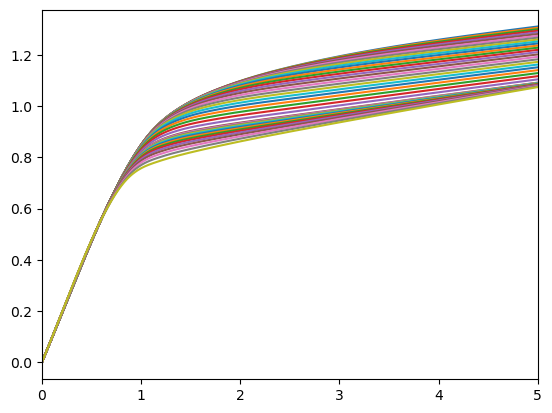

In [6]:
# Plot the consumption functions during working life

print("Consumption as a function of market resources while working:")
mMin = min([LifeCyclePop.solution[t].mNrmMin for t in range(LifeCyclePop.T_cycle)])
plot_funcs(LifeCyclePop.cFunc[: LifeCyclePop.T_retire], mMin, 5)

In [7]:
# Define the saving rate function
def savRteFunc(SomeType, m, t):
    """
    Parameters:
    ----------
        SomeType:
             Agent type that has been solved and simulated.
        m:
            normalized market resources of agent
        t:
            age of agent (from starting in the workforce)


    Returns:
    --------
        savRte: float

    """
    inc = (SomeType.Rfree - 1.0) * (
        m - 1.0
    ) + 1.0  # Normalized by permanent labor income
    cns = SomeType.solution[t].cFunc(m)  # Consumption (normalized)
    sav = inc - cns  # Flow of saving this period
    savRte = sav / inc  # Saving Rate
    return savRte

In [8]:
# Create a matrix gathering useful data:
# 't_now', 'aNrm_hist', 'cNrm_hist', employment-status in date t and date t-1,
# aLvlGro_hist, Saving rate

w, h = 1, LifeCyclePop.T_cycle
giant_list = [[0 for x in range(w)] for y in range(h)]
savRte_list = []


# Suppress some disturbing but harmless warnings
warnings.filterwarnings("ignore")

for t in range(1, LifeCyclePop.T_cycle + 1):
    # aLvlGro[0] = 0 # set the first growth rate to 0, since there is no data for period 0
    aLvlGroNow = np.log(
        (LifeCyclePop.history["aNrm"][t] * LifeCyclePop.history["pLvl"][t])
        / LifeCyclePop.history["aNrm"][t - 1]
        * LifeCyclePop.history["pLvl"][t - 1]
    )  # (10000,)

    # Call the saving rate function defined above
    savRte = savRteFunc(LifeCyclePop, LifeCyclePop.history["mNrm"][t], t)

    savRte_list.append(savRte)  # Add this period's saving rate to the list

    # Create elements of matrix list
    matrix_list = [0 for number in range(7)]
    matrix_list[0] = t
    matrix_list[1] = LifeCyclePop.history["aNrm"][t]
    matrix_list[2] = LifeCyclePop.history["cNrm"][t]
    matrix_list[3] = LifeCyclePop.history["TranShk"][t]
    matrix_list[4] = LifeCyclePop.history["TranShk"][t - 1]
    matrix_list[5] = aLvlGroNow
    matrix_list[6] = savRte

    giant_list[t - 1] = matrix_list

In [9]:
# Construct the level of assets A from a*p where a is the ratio to permanent income p
# Remember 41 is "years after entering workforce" (=age 25); 66 is the year right after retirement
LifeCyclePop.history["aLvl"] = (
    LifeCyclePop.history["aNrm"] * LifeCyclePop.history["pLvl"]
)
aGro41 = LifeCyclePop.history["aLvl"][41] / LifeCyclePop.history["aLvl"][40]
aGro41NoU = aGro41[
    aGro41[:] > 0.2
]  # Throw out extreme outliers; don't want growth rates relative to 0 income!

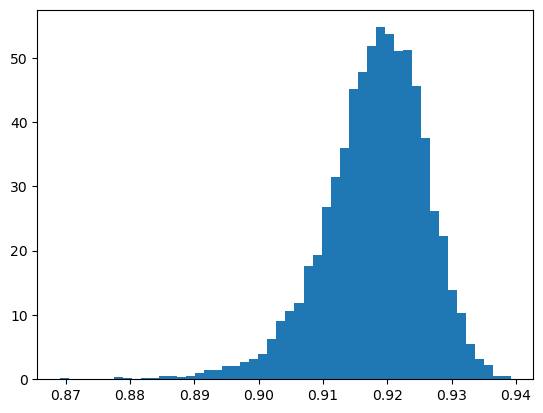

In [10]:
# Plot the (truncated) distribution of growth rates of wealth between age 65 and 66 (=25 + 41)

n, bins, patches = plt.hist(aGro41NoU, 50, density=True)

# Saving Rates and Lifetime Income Growth

We are interested in how income growth over the lifetime of the agent affects their saving rate and asset ratio $a=A/P$.


Text(0, 0.5, 'Normalized Assets')

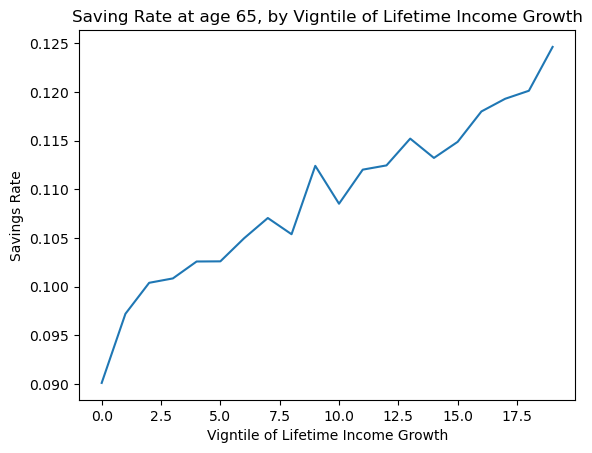

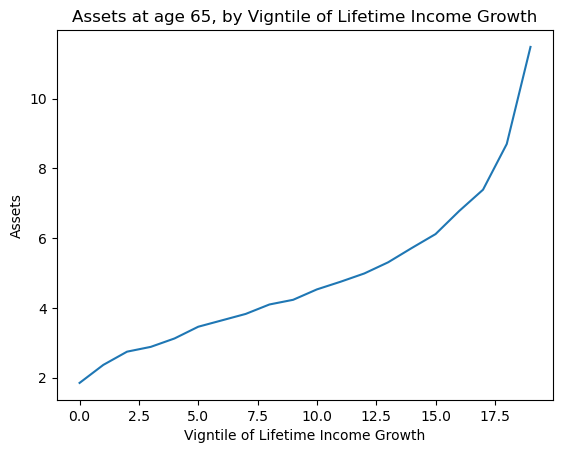

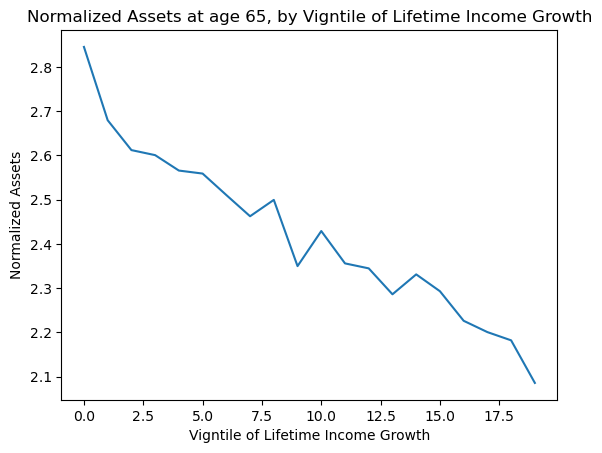

In [11]:
cumulative_income_first_half = np.sum(
    LifeCyclePop.history["pLvl"][0:20, :] * LifeCyclePop.history["TranShk"][0:20, :], 0
)
cumulative_income_second_half = np.sum(
    LifeCyclePop.history["pLvl"][20:40, :] * LifeCyclePop.history["TranShk"][20:40, :],
    0,
)
lifetime_growth = cumulative_income_second_half / cumulative_income_first_half

t = 39
vigntiles = pd.qcut(lifetime_growth, 20, labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.history["mNrm"][t], t)
savRtgueseByVigtile = np.zeros(20)
assetsByVigtile = np.zeros(20)
assetsNrmByVigtile = np.zeros(20)
savRteByVigtile = np.zeros(20)
for i in range(20):
    savRteByVigtile[i] = np.mean(savRte[vigntiles == i])
    assetsByVigtile[i] = np.mean(LifeCyclePop.history["aLvl"][t][vigntiles == i])
    assetsNrmByVigtile[i] = np.mean(LifeCyclePop.history["aNrm"][t][vigntiles == i])
plt.plot(np.array(range(20)), savRteByVigtile)
plt.title("Saving Rate at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Savings Rate")

plt.figure()
plt.plot(np.array(range(20)), assetsByVigtile)
plt.title("Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Assets")

plt.figure()
plt.plot(np.array(range(20)), assetsNrmByVigtile)
plt.title("Normalized Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Normalized Assets")